In [1]:
import sys
sys.path.append("../")
from src.utils.wandb_utils import get_config, config_to_omegaconf

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
user = "kealexanderwang"
project = "importance-reweighing"

run_names = [
    "quiet-sun-197",
    "efficient-pine-196",
    "lunar-plasma-195",
    "stilted-voice-191",
]

query = {"displayName": {"$in": run_names}}

In [4]:
from typing import Tuple
device = "cuda"

def init_model(name_config: Tuple[str, dict], ckpt_name="last.ckpt"):
    
    name, config = name_config
    config = config_to_omegaconf(config)
    run_dir = config["run_dir"]
    ckpt_path = f"{run_dir}/checkpoints/{ckpt_name}"
    
    config.trainer.gpus = 0  # don't use GPU for test time
    from src.train import hydra_init
    hydra_objs = hydra_init(config)
    
    model = hydra_objs.model
    import torch
    ckpt = torch.load(ckpt_path)
    model.load_state_dict(ckpt["state_dict"])
    model.eval()
    model.to(device)
    
    datamodule = hydra_objs.datamodule
    datamodule.setup()
    return model, datamodule

In [5]:
name_configs = get_config(user=user, project=project, query=query)

In [6]:
model_datamodule_lst = [init_model(name_config) for name_config in name_configs]

KeyboardInterrupt: 

In [ ]:
val_dataset = model_datamodule_lst[0][1].val_dataset
test_dataset = model_datamodule_lst[0][1].test_dataset
models = [m_d[0] for m_d in model_datamodule_lst]

In [ ]:
def to_ratio(group_dict):
    total = sum(group_dict.values())
    return {g: count / total for g, count in group_dict.items()}

# evaluate on average classifiers

In [8]:
import copy
averaged_model = copy.deepcopy(models[0])

In [9]:
averaged_model.state_dict().keys()

odict_keys(['class_weights', 'architecture.conv1.weight', 'architecture.bn1.weight', 'architecture.bn1.bias', 'architecture.bn1.running_mean', 'architecture.bn1.running_var', 'architecture.bn1.num_batches_tracked', 'architecture.layer1.0.downsample.0.weight', 'architecture.layer1.0.downsample.1.weight', 'architecture.layer1.0.downsample.1.bias', 'architecture.layer1.0.downsample.1.running_mean', 'architecture.layer1.0.downsample.1.running_var', 'architecture.layer1.0.downsample.1.num_batches_tracked', 'architecture.layer1.0.conv1.weight', 'architecture.layer1.0.bn1.weight', 'architecture.layer1.0.bn1.bias', 'architecture.layer1.0.bn1.running_mean', 'architecture.layer1.0.bn1.running_var', 'architecture.layer1.0.bn1.num_batches_tracked', 'architecture.layer1.0.conv2.weight', 'architecture.layer1.0.bn2.weight', 'architecture.layer1.0.bn2.bias', 'architecture.layer1.0.bn2.running_mean', 'architecture.layer1.0.bn2.running_var', 'architecture.layer1.0.bn2.num_batches_tracked', 'architecture

In [10]:
from typing import List, Dict
import torch

def average_params(target_state_dict: dict, other_state_dicts: List[dict], state_dict_keys: List[str]):
    for state_dict_key in state_dict_keys:
        other_params = [other[state_dict_key] for other in other_state_dicts]
        averaged_params = torch.stack(other_params, axis=0).mean(0)
        target_state_dict[state_dict_key] = averaged_params
    return target_state_dict

In [11]:
averaged_state_dict = average_params(averaged_model.state_dict(), [m.state_dict() for m in models], ["architecture.fc.weight", "architecture.fc.bias"])
averaged_model.load_state_dict(averaged_state_dict)

<All keys matched successfully>

In [ ]:
import torch
from torch.utils.data import DataLoader

averaged_model = averaged_model.to(device)

dataloader = DataLoader(test_dataset, batch_size=16)
y_trues = []
y_preds = []
group_ids = []
for x, y, g in dataloader:
    x = x.to(device)
    y = y.to(device)
    
    with torch.no_grad():
        batch = x, y
        _, _, y_pred, _, _ = averaged_model.step(batch)
    
    y_trues.append(y)
    y_preds.append(y_pred)
    group_ids.append(g)
    
y_trues = torch.cat(y_trues)
y_preds = torch.cat(y_preds)
group_ids = torch.cat(group_ids)

test_acc = (y_trues == y_preds).float().mean().item()

In [14]:
correct = (y_trues == y_preds).float()

# Groupby: https://twitter.com/jeremyphoward/status/1185062637341593600
idxs, vals = torch.unique(group_ids, return_counts=True)
vs = torch.split_with_sizes(correct, tuple(vals))
group_accs = {k.item(): v.mean().item() for k, v in zip(idxs, vs)}


# Groupby: https://twitter.com/jeremyphoward/status/1185062637341593600
idxs, vals = torch.unique(y_trues, return_counts=True)
vs = torch.split_with_sizes(correct, tuple(vals))
class_accs = {k.item(): v.mean().item() for k, v in zip(idxs, vs)}

In [15]:
print(test_acc)
print(group_accs)
print(class_accs)

0.45253708958625793
{0: 0.5263858437538147, 1: 0.488248348236084, 2: 0.35981306433677673, 3: 0.16043613851070404}
{0: 0.507317066192627, 1: 0.2601245939731598}


In [16]:
from collections import Counter
test_class_counts = Counter(y_trues.tolist())
test_group_counts = Counter(group_ids.tolist())

<ipython-input-23-94d128356039>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=[0, 1, 2, 3], xticks=x, ylim=[0, 1], title="SimCLR averaged undersampled linear classifer on Waterbirds", xlabel="Group")
<ipython-input-23-94d128356039>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=[0, 1, 2, 3], xticks=x, ylim=[0, 1], title="SimCLR averaged undersampled linear classifer linear classifer on Waterbirds", xlabel="Class")


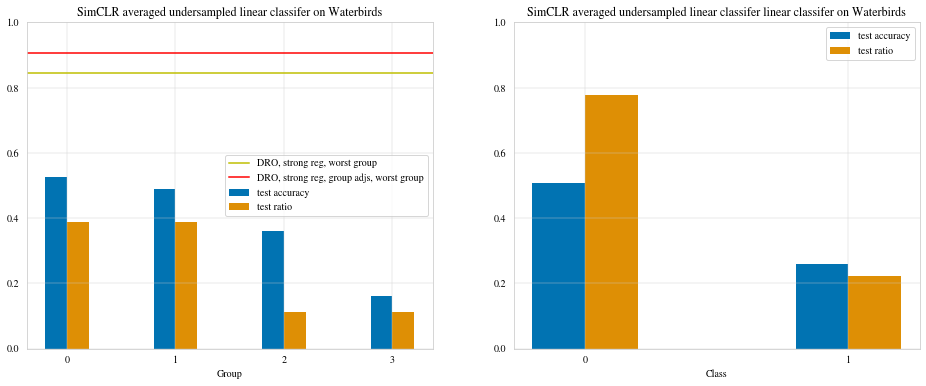

In [23]:
fig, axes = plt.subplots(figsize=(16, 6), ncols=2)

ax = axes[0]
x = np.arange(4)
ax.bar(np.array(list(group_accs.keys())) - 0.1, group_accs.values(), width=0.2, align="center", label="test accuracy")
ax.bar(np.array(list(to_ratio(test_group_counts).keys())) + 0.1, to_ratio(test_group_counts).values(), width=0.2, align="center", label="test ratio")
ax.set(xticklabels=[0, 1, 2, 3], xticks=x, ylim=[0, 1], title="SimCLR averaged undersampled linear classifer on Waterbirds", xlabel="Group")
ax.axhline(0.846, color='y', label="DRO, strong reg, worst group")
ax.axhline(0.905, color='r', label="DRO, strong reg, group adjs, worst group")
ax.legend()

ax = axes[1]
x = np.arange(2)
ax.bar(np.array(list(class_accs.keys())) - 0.1, class_accs.values(), width=0.2, align="center", label="test accuracy")
ax.bar(np.array(list((to_ratio(test_class_counts).keys()))) + 0.1, to_ratio(test_class_counts).values(), width=0.2, align="center", label="test ratio")
ax.set(xticklabels=[0, 1, 2, 3], xticks=x, ylim=[0, 1], title="SimCLR averaged undersampled linear classifer linear classifer on Waterbirds", xlabel="Class")
ax.legend()